In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_n with different $\sigma$

In [2]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [3]:
sid = 18
sigmas = [0.04, 0.05, 0.06]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL with different $neurons$

In [6]:
def run_NEFRL(sid, neurons):
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    trials = human['trial'].unique() 
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    for trial in trials:
        print(f"neurons {neurons}, sid {sid}, trial {trial}")
        env = Environment(dataset="carrabin", sid=sid, trial=trial, decay="stages", s=[mu,mu,mu,mu,mu])
        seed_net = sid + 1000*trial
        net = build_network_RL(env, n_neurons=neurons, seed_net=seed_net, z=0, a=5e-5)
        sim = nengo.Simulator(net, seed=trial, progress_bar=False)
        with sim:
            sim.run(env.Tall, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = sim.data[net.probe_prediction][tidx][0]
            df = pd.DataFrame([['NEF_RL', sid, trial, stage, qid, response]], columns=columns)
            dfs.append(df)
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['neurons'] = neurons
    return dynamics_data

In [10]:
sid = 18
# neurons = [10, 20]
neurons = [40, 85, 130]
# neurons = [40, 200, 1000]
dfs = []
for n in neurons:
    dfs.append(run_NEFRL(sid, n))
    print(dfs)
NEFRL_data = pd.concat(dfs, ignore_index=True)

neurons 40, sid 18, trial 1
neurons 40, sid 18, trial 2
neurons 40, sid 18, trial 3
neurons 40, sid 18, trial 4
neurons 40, sid 18, trial 5
neurons 40, sid 18, trial 6
neurons 40, sid 18, trial 7
neurons 40, sid 18, trial 8
neurons 40, sid 18, trial 9
neurons 40, sid 18, trial 10
neurons 40, sid 18, trial 11
neurons 40, sid 18, trial 12
neurons 40, sid 18, trial 13
neurons 40, sid 18, trial 14
neurons 40, sid 18, trial 15
neurons 40, sid 18, trial 16
neurons 40, sid 18, trial 17
neurons 40, sid 18, trial 18
neurons 40, sid 18, trial 19
neurons 40, sid 18, trial 20
neurons 40, sid 18, trial 21
neurons 40, sid 18, trial 22
neurons 40, sid 18, trial 23
neurons 40, sid 18, trial 24
neurons 40, sid 18, trial 25
neurons 40, sid 18, trial 26
neurons 40, sid 18, trial 27
neurons 40, sid 18, trial 28
neurons 40, sid 18, trial 29
neurons 40, sid 18, trial 30
neurons 40, sid 18, trial 31
neurons 40, sid 18, trial 32
neurons 40, sid 18, trial 33
neurons 40, sid 18, trial 34
neurons 40, sid 18, tri

# Plot Behavioral Learning Rate and Excursions

In [11]:
sid = 18
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
human['sigma'] = 'human'
human['neurons'] = 'human'
RLn_data['neurons'] = 'RLn'
NEFRL_data['sigma'] = 'NEF_RL'
combined = pd.concat([human, RLn_data, NEFRL_data], ignore_index=True)
combined['alpha'] = None
combined['excursion'] = None
for i, row in combined.iterrows():
    mt = row['type']
    trial = row['trial']
    stage = row['stage']
    qid = row['qid']
    n = row['neurons']
    response = row['response']
    avg_response = combined.query("type==@mt & neurons==@n & qid==@qid")['response'].mean()
    combined.at[i, 'excursion'] = response - avg_response
    if stage>1:
        stage_old = stage - 1
        response_old = combined.query("type==@mt & trial==@trial & neurons==@n & stage==@stage_old")['response'].to_numpy()[0]
        delta = response_old - response
        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
        prediction_error = color - response_old
        alpha = np.abs(delta / prediction_error)
        combined.at[i, 'alpha'] = alpha

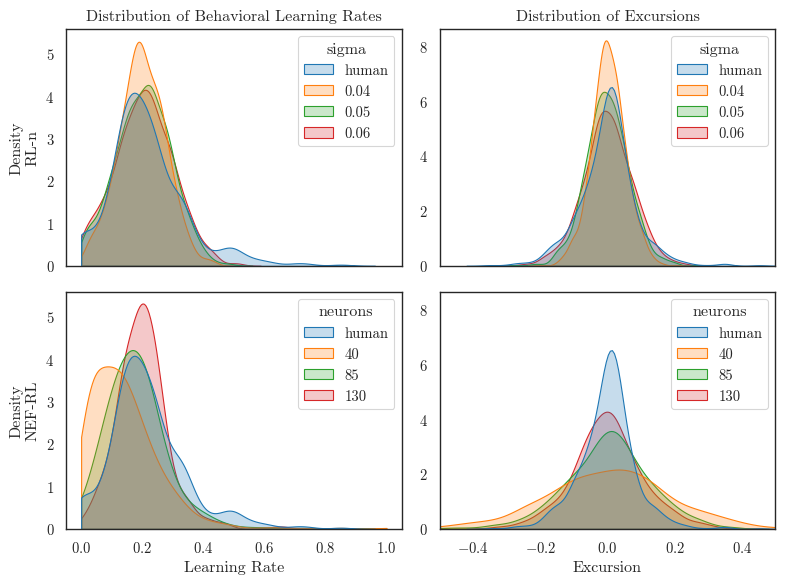

In [22]:
sigmas = combined["sigma"].unique()[1:]
neurons = combined["neurons"].unique()[1:]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
# plot learning rates on left
sns.kdeplot(combined.query("type!='NEF_RL'"), x='alpha', hue='sigma', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type!='RL_n'"), x='alpha', hue='neurons', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
# plot excursions on right
sns.kdeplot(combined.query("type!='NEF_RL'"), x='excursion', hue='sigma', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type!='RL_n'"), x='excursion', hue='neurons', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates', ylabel="Density\nRL-n")
axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
axes[1][0].set(ylabel="Density\nNEF-RL", xlabel="Learning Rate")
axes[1][1].set(ylabel=None, xlabel='Excursion')
plt.tight_layout()
fig.savefig("plots/alpha_excursions_vs_neurons_demo.jpg", dpi=600)